<a href="https://colab.research.google.com/github/CamilleGreen5/Deep_Learning_with_Python/blob/master/Noise_speech_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO :
- methode des masks donnent mauvais résultats (avec label)

## **DATA AND LIBRARIES LOADING**

In [ ]:
# !pip install pydub

In [ ]:
# !wget https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-5.1-2020-06-22/fr.tar.gz

In [3]:
# !tar -xf fr.tar.gz

In [67]:
# !rm fr.tar.gz
# !mkdir original
# !mkdir noisy
# !mkdir denoised
# !mkdir data
# !cp cv-corpus-5.1-2020-06-22/fr/clips/common_voice_fr_18157595.mp3 ./original

In [2]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.signal import stft, istft
import glob
from pydub import AudioSegment
from tensorflow.keras import models, layers
from tqdm.notebook import tqdm
import datetime
import os

## **FUNCTIONS LOAD**

In [4]:
def build_model():

    model = models.Sequential()
    model.add(layers.Dense(1000, activation='relu', input_shape=(501,)))
    model.add(layers.Dense(1000, activation='relu'))
    model.add(layers.Dense(501))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

In [5]:
def reshape_data(samples, labels=None):

    shapes = np.shape(samples)

    samples = np.transpose(samples)
    if labels is not None:
        labels = np.transpose(labels)

    samples = np.reshape(samples, (1, shapes[0]*2000, 501))
    if labels is not None:
        labels = np.reshape(labels, (1, shapes[0]*2000, 501))

    samples = np.squeeze(samples)
    if labels is not None:
        labels = np.squeeze(labels)

    return samples, labels

In [6]:
def add_noise(array_sound):
          
    max_1 = max(array_sound)
    noise = np.random.normal(0, 0.75, len(array_sound))
    array_sound_noisy = np.add(noise, array_sound)
    max_2 = max(array_sound_noisy)
    array_sound_noisy *= max_1/max_2

    return array_sound_noisy

In [7]:
def load_and_convert_data(train_mp3_data, add_noise_to_sample=False):

    samples = []
    im_samples = []
    i = 0

    for path_to_mp3_file in tqdm(train_mp3_data):

        # load mp3 sound to array
        loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
        array_sound = np.array(loaded_sound.get_array_of_samples(), np.float64)

        plt.plot([i for i in range(len(array_sound))], array_sound, 'b')
        plt.show()

        # normalize array
        mean = np.mean(array_sound, axis=0)
        std = np.std(array_sound)
        array_sound -= mean
        array_sound /= std

        if add_noise_to_sample:
            array_sound = add_noise(array_sound)

        # convert sample to to F_T_space
        f, t, array_stft = stft(array_sound, fs=48000, nperseg=1000)
        sample_abs_stft = np.abs(array_stft)
        sample_im_stft = np.imag(array_stft)

        # padding 
        pad_length = 2000 - np.shape(sample_abs_stft)[1]
        sample_abs_stft = np.pad(sample_abs_stft, ((0,0), (0, pad_length)))
        sample_im_stft = np.pad(sample_im_stft, ((0,0), (0, pad_length)))

        samples.append(sample_abs_stft)
        im_samples.append(sample_im_stft)
        i+=1

    samples = np.array(samples)
    im_samples = np.array(im_samples)

    return samples, im_samples, mean, std

In [8]:
def denoising(samples, im_samples, mean, std):
    
    # load model
    model = tf.keras.models.load_model('./model/mymodel')

    # predict
    samples, x = reshape_data(samples)
    im_samples, x = reshape_data(im_samples)

    denoised_samples = model.predict(samples)
    
    denoised_stft = denoised_samples + 1j*im_samples

    # convert back to sound from F_T_space
    t, desnoised_array_sound = istft(denoised_stft, fs=48000, nperseg=1000)
    desnoised_array_sound = np.array(desnoised_array_sound)
    desnoised_array_sound *= std
    desnoised_array_sound += mean
    desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

    plt.plot([i for i in range(len(desnoised_array_sound))], desnoised_array_sound, 'r')
    plt.show()

    return desnoised_array_sound


In [9]:
def load_and_convert_data_with_label(train_mp3_data):

    i = 0

    for path_to_mp3_file in tqdm(train_mp3_data):

        # load mp3 sound to array
        loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
        array_sound = np.array(loaded_sound.get_array_of_samples(), np.float64)

        # normalize array
        mean = np.mean(array_sound, axis=0)
        std = np.std(array_sound)
        array_sound -= mean
        array_sound /= std

        # convert label to to F_T_space
        f, t, array_stft = stft(array_sound, fs=48000, nperseg=1000)
        original_abs_stft = np.abs(array_stft)

        # padding 
        pad_length = 2000 - np.shape(original_abs_stft)[1]
        original_abs_stft = np.pad(original_abs_stft, ((0,0), (0, pad_length)))

        # add random noise
        array_sound_noisy = add_noise(array_sound)

        # convert sample to to F_T_space
        f, t, array_stft = stft(array_sound_noisy, fs=48000, nperseg=1000)
        sample_abs_stft = np.abs(array_stft)

        # padding 
        pad_length = 2000 - np.shape(sample_abs_stft)[1]
        sample_abs_stft = np.pad(sample_abs_stft, ((0,0), (0, pad_length)))

        # convertion to image format
        sample_abs_stft = np.stack((sample_abs_stft, original_abs_stft, np.zeros_like(sample_abs_stft)))
        # print(np.shape(sample_abs_stft))

        # saving images
        path_sample = str("./data/folder1/sample" + str(i) + ".jpg")
        tf.keras.preprocessing.image.save_img(path_sample, sample_abs_stft, data_format='channels_first', scale=True)

        # free space
        path = train_mp3_data[i]
        try:
            os.remove(path)
        except FileNotFoundError:
            continue

        i+=1
    

## **DATA CONVERSION**

In [ ]:
# !rm labels/*
# !rm samples/folder1/*

In [10]:
list_mp3_files = glob.glob("./cv-corpus-5.1-2020-06-22/fr/clips/*.mp3")
train_mp3_data = list_mp3_files[:-2000]
test_mp3_data = list_mp3_files[-2000:]
# print(len(train_mp3_data))

In [166]:
load_and_convert_data_with_label(train_mp3_data[:50])

## **MODEL FITING**

In [21]:
NEW_MODEL = True

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

if NEW_MODEL:
    model = build_model()
else:
    model = tf.keras.models.load_model("model/mymodel")


dataset = tf.data.Dataset.from_generator(create_generator, output_types=(tf.int16, tf.int16))
for element in dataset:
    sample = np.array(element[0])
    label = np.array(element[1])
    print(np.shape(sample))
    print(np.shape(label))
    # saving images
    path_sample = str("./temp/sample0.jpg")
    sample = np.stack((sample, sample, sample))
    tf.keras.preprocessing.image.save_img(path_sample, sample, data_format='channels_first', scale=True)
    break


# model.fit(dataset, epochs=50, shuffle=True, callbacks=[tensorboard_callback])

# model.save('./model/mymodel')
# print('model saved')


Found 100 images belonging to 2 classes.
(2000, 501)
(2000, 501)


In [12]:
def data_generator():
    img_gen = tf.keras.preprocessing.image.ImageDataGenerator()
    samples_and_labels = img_gen.flow_from_directory("./samples/", class_mode=None, target_size=(501, 2000), batch_size=1)
    for sample_and_label in samples_and_labels:
        sample_and_label = np.array(sample_and_label)
        sample = sample_and_label[:,:,:,0]
        label = sample_and_label[:,:,:,1]
        sample = np.reshape(sample, (2000, 501))
        label = np.reshape(label, (2000, 501))
        yield(sample, label)
        
def create_generator():
    gen = data_generator()
    return gen

## **VISUALISATION AND TEST**

In [ ]:
%tensorboard --logdir logs/fit --host localhost

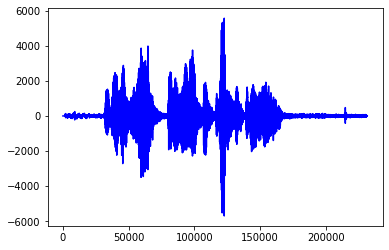


(2000, 501)
(2000, 501)
(0.00010738041601143777+0j)
(250000,)
-2


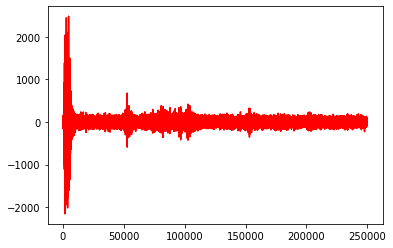

(250000,)


In [ ]:
list_files = ["./original/common_voice_fr_18157595.mp3"]
samples, im_samples, mean, std = load_and_convert_data(list_files, True)

denoised_array_sound = denoising(samples, im_samples, mean, std)

print(np.shape(denoised_array_sound))

# save reconverted sound to wav
path_to_wav_file = './denoised/denoised_sound0.wav'
write(path_to_wav_file, 48000, denoised_array_sound)
    

## **TEST**

In [ ]:
# load mp3 sound to array
mp3_sound = AudioSegment.from_mp3("./original/common_voice_fr_18157595.mp3")
array_sound_mp3 = np.array(mp3_sound.get_array_of_samples())

# save original to wav
path_to_wav_file = './noised/noised_sound0.wav'
write(path_to_wav_file, 48000, array_sound_mp3)

# save to mp3 from wav
mp3_sound_save = AudioSegment.from_wav(path_to_wav_file)
mp3_sound_save.export('./original/noised_sound0.mp3', format='mp3')

# load wav sound to array
samplerate, wav_sound = read("./noised/noised_sound0.wav")
array_sound_wav = np.array(wav_sound, np.float64)

# # plot
# plt.plot([i for i  in range(len(array_sound_wav))], array_sound_wav, 'b')
# plt.show()
# plt.plot([i for i  in range(len(array_sound_mp3))], array_sound_mp3, 'r')
# plt.show()


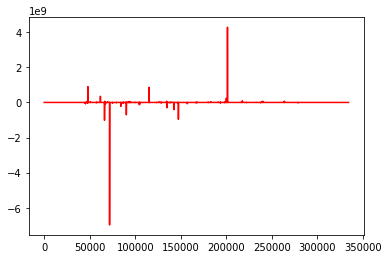

In [ ]:
for i, path_to_mp3_file in enumerate(list_mp3_files[1:2]):

    # load mp3 sound to array
    loaded_sound = AudioSegment.from_mp3(path_to_mp3_file)
    array_sound = np.array(loaded_sound.get_array_of_samples(), np.float64)

    # normalize array
    mean = np.mean(array_sound, axis=0)
    std = np.std(array_sound)
    array_sound -= mean
    array_sound /= std

    # add random noise
    max_1 = max(array_sound)
    noise = np.random.normal(0, 0.75, len(array_sound))
    array_sound_noisy = np.add(noise, array_sound)
    max_2 = max(array_sound_noisy)
    array_sound_noisy *= max_1/max_2
    
    # # save original to wav
    # array_sound_noisy_to_save = array_sound_noisy * std
    # array_sound_noisy_to_save += mean
    # array_sound_noisy_to_save = np.array(array_sound_noisy_to_save, np.int16)
    # path_to_wav_file = './noised/noised_sound0.wav'
    # write(path_to_wav_file, 48000, array_sound_noisy_to_save)

    # denoised = np.where(np.sqrt(array_sound_noisy**2-array_sound**2)>array_sound_noisy/3, 0, array_sound_noisy)
    # mask = np.where(0<=(array_sound**2)/(noise**2),(array_sound**2)/(noise**2), 0)
    # mask = np.where(mask<1,mask, 1)
    mask = (array_sound**2)/(noise**2)

    denoised = array_sound_noisy * mask

    # plot original and noisy
    # plt.plot([i for i  in range(len(noise))], noise, 'r')
    # plt.plot([i for i  in range(len(array_sound))], array_sound, 'b')
    # plt.plot([50000+i for i  in range(1000)], mask[50000:51000], 'r')
    plt.plot([i for i  in range(len(denoised))], denoised, 'r')
    plt.show()

    # save reconverted sound to wav
    path_to_wav_file = './denoised/denoised_sound0.wav'
    write(path_to_wav_file, 48000, denoised)

    # # convert sound to to F_T_space
    # f, t, array_stft = stft(array_sound_noisy, fs=48000, nperseg=1000)
    # array_abs_stft = np.abs(array_stft)

    # plt.pcolormesh(t, f, array_abs_stft)
    # plt.title('STFT Magnitude')
    # plt.ylabel('Frequency [Hz]')
    # plt.xlabel('Time [sec]')
    # plt.show()

    # # convert back to sound from F_T_space
    # t, desnoised_array_sound = istft(array_stft, fs=48000, nperseg=1000)
    # desnoised_array_sound = np.array(desnoised_array_sound)
    # desnoised_array_sound *= std
    # desnoised_array_sound += mean
    # desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

    # # save reconverted sound to wav
    # path_to_wav_file = './denoised/denoised_sound' + str(i) + '.wav'
    # write(path_to_wav_file, 48000, desnoised_array_sound)
    

In [ ]:
for path_to_mp3_file in tqdm(train_mp3_data):
    # print(i)
    a =1



100%|██████████| 500/500 [00:00<00:00, 310643.16it/s]


In [ ]:

samples, labels, mean, std = load_and_convert_data_with_label(list_mp3_files[1:2])

print(np.shape(samples))
print(np.shape(labels))

desnoised_array_stft = samples[0]*labels[0]

# convert back to sound from F_T_space
t, desnoised_array_sound = istft(desnoised_array_stft, fs=48000, nperseg=1000)
desnoised_array_sound = np.array(desnoised_array_sound)
desnoised_array_sound *= std
desnoised_array_sound += mean
desnoised_array_sound = np.array(desnoised_array_sound, np.int16)

# save reconverted sound to wav
path_to_wav_file = './denoised/denoised_sound0.wav'
write(path_to_wav_file, 48000, desnoised_array_sound)




(1, 501, 2000)
(1, 501, 2000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


In [ ]:
a = np.array([ 1 + 1j, 1 + 1j, 1 + 1j])
b = np.abs(a)
c = np.imag(a)
d = b + 1j*c
print(d)

[1.41421356+1.j 1.41421356+1.j 1.41421356+1.j]
